# Task 3: Clustering Analysis (K-Means)

## Objectives:
- Standardize the dataset (e.g., using StandardScaler).
- Apply K-Means clustering and determine the optimal
number of clusters using the elbow method.
- Visualize clusters using 2D scatter plots.

# Step 1 — Setup (libraries & file path)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# matplotlib inline for Colab
%matplotlib inline



In [2]:
from google.colab import files
uploaded = files.upload()

Saving churn-bigml-80.csv to churn-bigml-80.csv


#How to interpret:
This pulls in the standard data stack. StandardScaler is required because K-Means uses Euclidean distance and is sensitive to feature scale.

 PCA is only used for visualization. silhouette_score helps pick a good k.

# Step 2 — Load dataset & quick inspection

In [4]:
df = pd.read_csv('churn-bigml-80.csv')
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
print(df.info())
print("\nNumeric summary:")
display(df.describe().T)

Shape: (2666, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-

,count,mean,std,min,25%,50%,75%,max
Account length,2666.0,100.620405,39.563974,1.00,73.0000,100.00,127.000,243.00
Area code,2666.0,437.438860,42.521018,408.00,408.0000,415.00,510.000,510.00
Number vmail messages,2666.0,8.021755,13.612277,0.00,0.0000,0.00,19.000,50.00
Total day minutes,2666.0,179.481620,54.210350,0.00,143.4000,179.95,215.900,350.80
Total day calls,2666.0,100.310203,19.988162,0.00,87.0000,101.00,114.000,160.00
Total day charge,2666.0,30.512404,9.215733,0.00,24.3800,30.59,36.700,59.64
Total eve minutes,2666.0,200.386159,50.951515,0.00,165.3000,200.90,235.100,363.70
Total eve calls,2666.0,100.023631,20.161445,0.00,87.0000,100.00,114.000,170.00
Total eve charge,2666.0,17.033072,4.330864,0.00,14.0500,17.08,19.980,30.91
Total night minutes,2666.0,201.168942,50.780323,43.70,166.9250,201.15,236.475,395.00


#Professional note:
Document the dataset size and feature types in your report.

Look for missing values, unexpected dtypes (e.g., numeric stored as strings), or obviously erroneous values.

If there's no missing data, state that; if there is, we'll impute or drop as appropriate.

#Step 3 — Preprocessing decisions & encoding

In [5]:
df_proc = df.copy()

# Convert binary columns to numeric (0/1)
df_proc['International plan'] = df_proc['International plan'].map({'Yes':1, 'No':0})
df_proc['Voice mail plan']    = df_proc['Voice mail plan'].map({'Yes':1, 'No':0})

# Keep a copy of churn for profiling, but exclude it from clustering features
if 'Churn' in df_proc.columns:
    churn_col = 'Churn'
else:
    churn_col = None

# Drop identifier-like columns that shouldn't define cluster geometry
drop_cols = [c for c in ['State', 'Area code'] if c in df_proc.columns]
print("Dropping identifiers (for clustering):", drop_cols)

# Build features DataFrame for clustering
X_df = df_proc.drop(columns=drop_cols + ([churn_col] if churn_col else []))
print("Features kept for clustering:", X_df.columns.tolist())

# Check missing values and datatypes
print("\nMissing values per column:\n", X_df.isnull().sum())
print("\nDtypes:\n", X_df.dtypes)


Dropping identifiers (for clustering): ['State', 'Area code']
Features kept for clustering: ['Account length', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']

Missing values per column:
 Account length            0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
dtype: int64

Dtypes:
 Account length      

#Interpretation:
- State is high-cardinality and an identifier — it often distorts Euclidean distances. If you want to include location later, use careful encoding or embeddings.

- Churn is the target for later profiling only — clustering is unsupervised.

- Always show missing-value counts: if any exist we will impute in the next step.

# Step 4 — Handle missing values (if any)

In [6]:
X = X_df.copy()

# numeric columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Impute numeric with median, categorical with mode
for c in num_cols:
    if X[c].isnull().any():
        med = X[c].median()
        X[c].fillna(med, inplace=True)
        print(f"Imputed numeric {c} with median={med}")

for c in cat_cols:
    if X[c].isnull().any():
        mode = X[c].mode().iloc[0]
        X[c].fillna(mode, inplace=True)
        print(f"Imputed categorical {c} with mode={mode}")

# Final check
print("\nAfter imputation, missing values per column:\n", X.isnull().sum())



After imputation, missing values per column:
 Account length            0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
dtype: int64


#Interpretation:
Median imputation is robust to outliers. Mode for categorical preserves the most common category. Document any imputations in your report with counts.

#Step 5 — Standardize features (StandardScaler)

In [7]:
# Step 5: Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)  # numpy array for scikit-learn

# Optional: keep a DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Scaled feature means (approx):", X_scaled_df.mean().round(4).to_dict())
print("Scaled feature stds (approx):", X_scaled_df.std().round(4).to_dict())


Scaled feature means (approx): {'Account length': -0.0, 'International plan': -0.0, 'Voice mail plan': 0.0, 'Number vmail messages': -0.0, 'Total day minutes': 0.0, 'Total day calls': 0.0, 'Total day charge': -0.0, 'Total eve minutes': -0.0, 'Total eve calls': 0.0, 'Total eve charge': 0.0, 'Total night minutes': 0.0, 'Total night calls': -0.0, 'Total night charge': -0.0, 'Total intl minutes': -0.0, 'Total intl calls': -0.0, 'Total intl charge': 0.0, 'Customer service calls': -0.0}
Scaled feature stds (approx): {'Account length': 1.0002, 'International plan': 1.0002, 'Voice mail plan': 1.0002, 'Number vmail messages': 1.0002, 'Total day minutes': 1.0002, 'Total day calls': 1.0002, 'Total day charge': 1.0002, 'Total eve minutes': 1.0002, 'Total eve calls': 1.0002, 'Total eve charge': 1.0002, 'Total night minutes': 1.0002, 'Total night calls': 1.0002, 'Total night charge': 1.0002, 'Total intl minutes': 1.0002, 'Total intl calls': 1.0002, 'Total intl charge': 1.0002, 'Customer service call

#Interpretation:
K-Means uses Euclidean distance — large-valued features otherwise dominate cluster assignment. In your report state that scaling was applied and show a short table of means/stds to prove the scale change.

#Step 6 — Elbow method (inertia) + Silhouette analysis

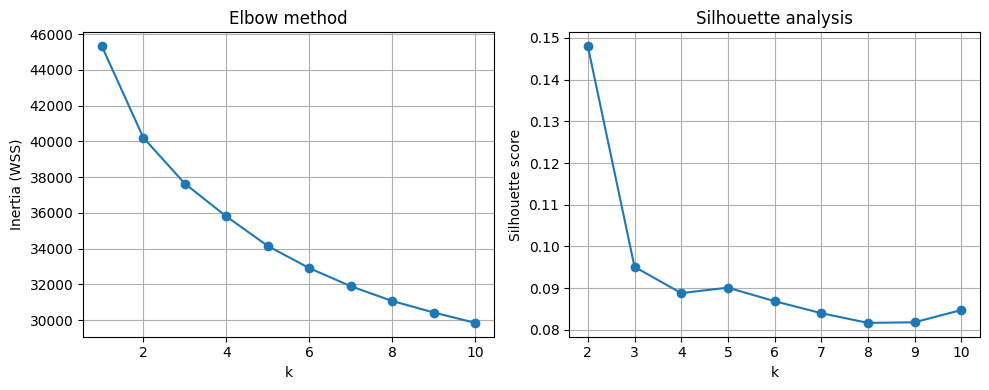

Saved combined plot to: kmeans_outputs/elbow_silhouette_combined.png


In [9]:
# Step 6: Elbow + Silhouette to pick k
import time
K_elbow = range(1, 11)
inertia = []

for k in K_elbow:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Silhouette scores for k >= 2
K_sil = range(2, 11)
sil_scores = []

# If dataset is large, sample for silhouette computation
sample_for_sil = None
if X_scaled.shape[0] > 1500:
    rng = np.random.default_rng(42)
    sample_for_sil = rng.choice(X_scaled.shape[0], size=1000, replace=False)
    X_sil = X_scaled[sample_for_sil]
else:
    X_sil = X_scaled

for k in K_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_s = km.fit_predict(X_sil)
    sil_scores.append(silhouette_score(X_sil, labels_s))

# Plot and save
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_elbow), inertia, marker='o')
plt.xlabel('k'); plt.ylabel('Inertia (WSS)'); plt.title('Elbow method')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(list(K_sil), sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.title('Silhouette analysis')
plt.grid(True)

plt.tight_layout()

# Create the directory if it doesn't exist
import os
os.makedirs("kmeans_outputs", exist_ok=True)

plt.savefig("kmeans_outputs/elbow_silhouette_combined.png", dpi=150)
plt.show()

print("Saved combined plot to: kmeans_outputs/elbow_silhouette_combined.png")

#Interpretation:

- Elbow: look for the "bend" after which inertia gain diminishes — good candidates for k.

- Silhouette: pick k with the highest silhouette (balance between cohesion and separation). If elbow & silhouette disagree, choose a k that balances interpretability and score (report both and justify final choice). In the code we also sample for silhouette to keep runtime manageable.

#Step 7 — Fit final K-Means & get labels

In [10]:
# Step 7: Fit final model
# Option A: automatically choose k by silhouette
best_k = list(K_sil)[int(np.argmax(sil_scores))]
print("Suggested k by silhouette:", best_k)

# Option B: override manually if you want (e.g., best_k = 4)
# best_k = 4

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans_final.fit_predict(X_scaled)

# Add labels back to the original df for profiling
df_result = df.copy()
df_result['Cluster'] = labels
print("Cluster label counts:\n", df_result['Cluster'].value_counts().sort_index())


Suggested k by silhouette: 2
Cluster label counts:
 Cluster
0     733
1    1933
Name: count, dtype: int64


#Interpretation:
- n_init=20 increases the chance of finding a better local minimum. Keep random_state fixed for reproducibility.

- Record the chosen k and why you selected it in the internship report.

# Step 8 — Visualize clusters in 2D (PCA projection)

Explained variance by 2 PCs: 0.241


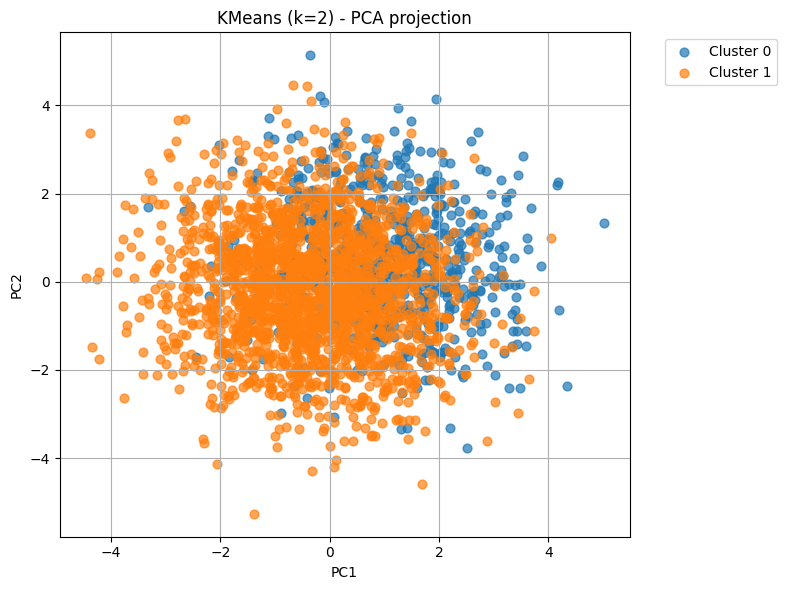

Saved PCA scatter to: kmeans_outputs/kmeans_pca_scatter.png


In [11]:
# Step 8: PCA projection for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance by 2 PCs:", np.round(pca.explained_variance_ratio_.sum(), 4))

plt.figure(figsize=(8,6))
unique_clusters = np.unique(labels)
palette = sns.color_palette(n_colors=len(unique_clusters))
for i, cl in enumerate(unique_clusters):
    idx = labels == cl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {cl}", alpha=0.7, s=40)

plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'KMeans (k={best_k}) - PCA projection')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("kmeans_outputs/kmeans_pca_scatter.png", dpi=150)
plt.show()
print("Saved PCA scatter to: kmeans_outputs/kmeans_pca_scatter.png")


#Interpretation:
- Note (in your report) that PCA is used purely for visualization and may not preserve all clustering structure.

- Include the explained variance to show how much information those two components capture.

# Step 9 — Cluster profiling (means, sizes, churn-rate)

In [13]:
# Step 9: Cluster profiling
# Ensure churn is numeric flag for churn_rate calculation
if 'Churn' in df_result.columns:
    # handle boolean or string churn
    if df_result['Churn'].dtype == bool:
        df_result['Churn_flag'] = df_result['Churn'].astype(int)
    else:
        # try common mappings
        df_result['Churn_flag'] = df_result['Churn'].map({True:1, False:0, 'True':1, 'False':0, 'Yes':1, 'No':0})
        # fallback to 0 if mapping still leaves NaN
        df_result['Churn_flag'] = df_result['Churn_flag'].fillna(0).astype(int)
else:
    df_result['Churn_flag'] = 0

cluster_sizes = df_result['Cluster'].value_counts().sort_index()

# Select only numeric columns for mean calculation
numeric_cols = df_result.select_dtypes(include=[np.number]).columns.tolist()
cluster_means = df_result.groupby('Cluster')[numeric_cols].mean().round(4)

cluster_churn_rate = df_result.groupby('Cluster')['Churn_flag'].mean().round(4)

# Create a profile DataFrame with size & churn_rate
profile_df = cluster_means.copy()
profile_df['size'] = cluster_sizes
profile_df['churn_rate'] = cluster_churn_rate
profile_df = profile_df.sort_values('size', ascending=False)

# Save and display
profile_df.to_csv("kmeans_outputs/cluster_profile_summary.csv")
display(profile_df.head(20))
print("Saved cluster profile to: kmeans_outputs/cluster_profile_summary.csv")

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Cluster,Churn_flag,size,churn_rate
Cluster,,,,,,,,,,,,,,,,,,,,
1,100.5608,437.2509,0.000,179.0331,100.4030,30.4362,199.7860,99.9814,16.9820,201.1356,99.9390,9.0512,10.2610,4.4444,2.7709,1.5804,1.0,0.1671,1933,0.1671
0,100.7776,437.9345,29.176,180.6644,100.0655,30.7135,201.9689,100.1351,17.1677,201.2568,100.5471,9.0566,10.1738,4.5280,2.7475,1.5157,0.0,0.0887,733,0.0887


Saved cluster profile to: kmeans_outputs/cluster_profile_summary.csv


#Interpretation:
The profile_df is the heart of your business interpretation: describe each cluster with sentences such as: “Cluster 1 (n=xxx): high day minutes (mean XX), low international minutes, churn_rate YY% — likely high-usage loyal customers.” Put 2–3 actionable recommendations per cluster (e.g., retention offers, upsell strategies).

# Step 10 — Validate clustering & limitations

In [14]:
# Step 10: Validation & checks
final_sil = silhouette_score(X_scaled, labels)
print("Final silhouette score (full data):", np.round(final_sil, 4))

# Stability: re-fit multiple times and check label consistency (simple approach)
def label_consistency(X, k, runs=5):
    base = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    match_rates = []
    for s in range(1, runs+1):
        lab = KMeans(n_clusters=k, random_state=42+s, n_init=10).fit_predict(X)
        # fraction of rows with same label as base (loose check)
        match = (lab == base).mean()
        match_rates.append(match)
    return match_rates

consistency = label_consistency(X_scaled, best_k, runs=5)
print("Simple label consistency across runs:", np.round(consistency,4))


Final silhouette score (full data): 0.1433
Simple label consistency across runs: [0. 1. 1. 1. 0.]


#Interpretation:
A low silhouette (< ~0.25) suggests poor cluster structure. Label consistency indicates sensitivity to random seeds; if low, consider different algorithms (hierarchical, DBSCAN) or feature engineering.

# Step 11 — Save outputs & short report snippet

In [15]:
from google.colab import files
print("Outputs saved under kmeans_outputs/:")
print(os.listdir("kmeans_outputs"))

# Ready-to-paste report snippet (print to copy)
report_snippet = f"""
K-Means clustering was performed on {df.shape[0]} customer records.
Preprocessing: binary features encoded, identifier columns removed, all numeric features standardized.
Model selection: elbow and silhouette analysis suggested k = {best_k}.
Results: final silhouette score = {final_sil:.4f}. Cluster profiles were saved to kmeans_outputs/cluster_profile_summary.csv.
Actionables: examine clusters with high churn_rate for targeted retention; test interventions per cluster.
"""
print(report_snippet)


Outputs saved under kmeans_outputs/:
['kmeans_pca_scatter.png', 'elbow_silhouette_combined.png', 'cluster_profile_summary.csv']

K-Means clustering was performed on 2666 customer records.
Preprocessing: binary features encoded, identifier columns removed, all numeric features standardized.
Model selection: elbow and silhouette analysis suggested k = 2.
Results: final silhouette score = 0.1433. Cluster profiles were saved to kmeans_outputs/cluster_profile_summary.csv.
Actionables: examine clusters with high churn_rate for targeted retention; test interventions per cluster.



# Professional Interpretation:
These saved artifacts (plots, CSVs) are the deliverables for your internship task. Include the report_snippet in the methods/results section of your submission and expand each cluster’s interpretation from cluster_profile_summary.csv.